In [10]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.ndimage
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
# import tensorflow_addons as tfa
# from tfa.layers import flatten
%matplotlib inline

In [11]:
training_file = "data/train.pickle"
validation_file= "data/valid.pickle"
testing_file = "data/test.pickle"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

print("X_train shape:", X_train[0].shape)
print("y_train shape:", y_train.shape)
print("X_valid shape:", X_valid[0].shape)
print("y_valid shape:", y_valid.shape)
print("X_test shape:", X_test[0].shape)
print("y_test shape:", y_test.shape)

X_train shape: (32, 32, 3)
y_train shape: (34799,)
X_valid shape: (32, 32, 3)
y_valid shape: (4410,)
X_test shape: (32, 32, 3)
y_test shape: (12630,)


In [12]:
n_train = len(X_train)
n_valid = len(X_valid)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))

In [13]:
print("Number of training examples = ", n_train)
print("Number of validation example = ", n_valid)
print("Number of testing samples = ", n_test)
print("Shape of first training image = ", image_shape[0], "w x", image_shape[1], "h x", image_shape[2], "d")
print("Number of classes = ", n_classes)

Number of training examples =  34799
Number of validation example =  4410
Number of testing samples =  12630
Shape of first training image =  32 w x 32 h x 3 d
Number of classes =  43


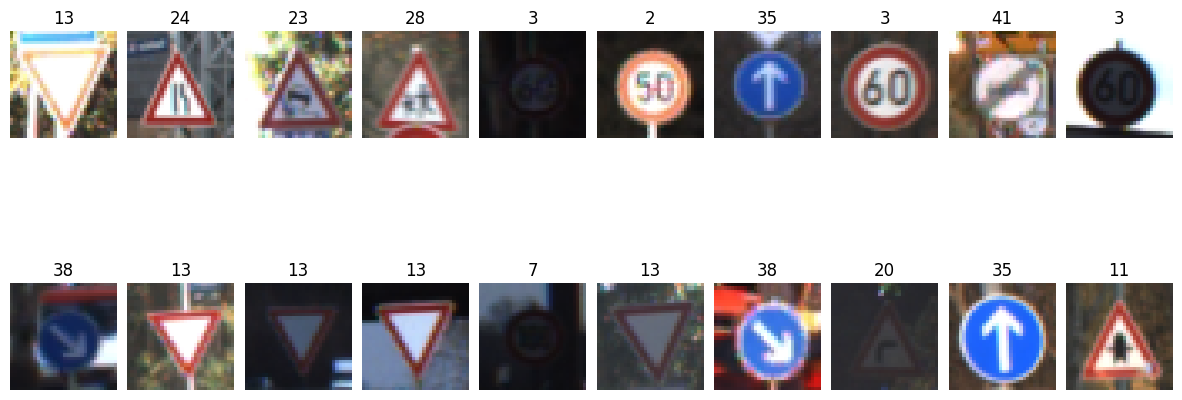

In [14]:
fig, axs = plt.subplots(2,10, figsize=(15,6))
fig.subplots_adjust(hspace=.2, wspace=.1)
axs = axs.ravel()

for i in range(20):
    index = random.randint(0,len(X_train))
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])

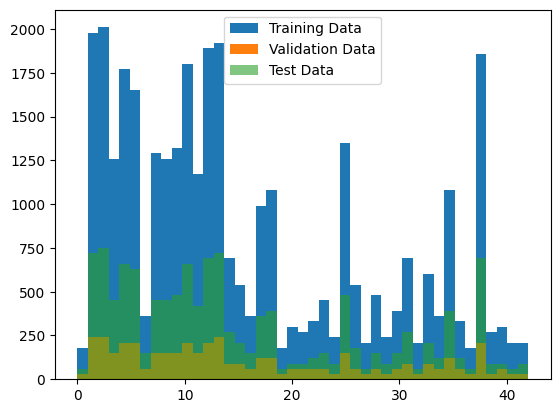

In [15]:
a = y_train
b = y_valid
c = y_test
bins = n_classes

plt.hist(a, bins, alpha=1, label='Training Data')
plt.hist(b, bins, alpha=1, label='Validation Data')
plt.hist(c, bins, alpha=0.6, label='Test Data')
plt.legend(loc='upper center')

plt.show()

In [16]:
# rotation

degrees = 10
degrees_positive = 10
degrees_negative = 350
X_train_rotated_positive = []
X_train_rotated_negative = []

for i in range(len(X_train)):
    rotated_image = scipy.ndimage.rotate(X_train[i], degrees_positive)
    X_train_rotated_positive.append(rotated_image)

for i in range(len(X_train)):
    rotated_image = scipy.ndimage.rotate(X_train[i], degrees_negative)
    X_train_rotated_negative.append(rotated_image)

for i in range(len(X_train_rotated_positive)):
    X_train_rotated_positive[i] = X_train_rotated_positive[i][2:34,2:34]

for i in range(len(X_train_rotated_negative)):
    X_train_rotated_negative[i] = X_train_rotated_negative[i][2:34,2:34]

X_train = list(X_train)

for i in range(len(X_train_rotated_positive)):
    X_train.append(X_train_rotated_positive[i])
    X_train.append(X_train_rotated_negative[i])

y_train = list(y_train)

for i in range(len(y_train)):
    y_train.append(y_train[i])
    y_train.append(y_train[i])

X_train = np.array(X_train)
new_n_train = len(X_train)

y_train = np.array(y_train)
new_n_train_y = len(y_train)

print("New number of ground truth labels = ", new_n_train_y)
print("New number of training samples after data augmentation = ", new_n_train)

New number of ground truth labels =  104397
New number of training samples after data augmentation =  104397


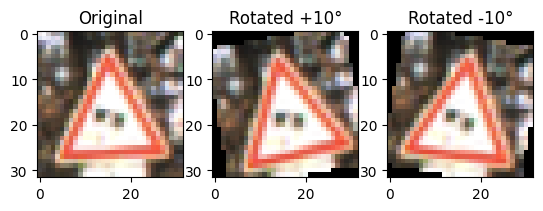

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(X_train[2018])
ax1.set_title('Original')
ax1.axis('ON')
ax2.imshow(X_train_rotated_positive[2018])
ax2.set_title('Rotated +10°')
ax2.axis('ON')
ax3.imshow(X_train_rotated_negative[2018])
ax3.set_title('Rotated -10°')
ax3.axis('ON')
plt.savefig('./examples/Figure_original_rotated.jpg', dpi=300)
plt.show()

In [18]:
X_train, y_train = shuffle(X_train, y_train)

print("shuffle complete")

shuffle complete


In [19]:
def normalize(image):
    normal = (image - 127.5)/255
    return np.reshape(normal, (32,32,1))

In [20]:
def grayscale(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return np.reshape(gray, (32,32,1))

In [21]:
def equalize(image):
    equal = cv2.equalizeHist(image)
    return np.reshape(equal, (32,32,1))

In [22]:
X_train_normalized = []

for image in X_train:
    gray_image = grayscale(image)
    equal_image = equalize(gray_image)
    normalized_image = normalize(equal_image)
    X_train_normalized.append(normalized_image)

In [23]:
X_valid_normalized = []

for image in X_valid:
    gray_image = grayscale(image)
    equal_image = equalize(gray_image)
    normalized_image = normalize(equal_image)
    X_valid_normalized.append(normalized_image)

In [24]:
X_test_normalized = []

for image in X_test:
    gray_image = grayscale(image)
    equal_image = equalize(gray_image)
    normalized_image = normalize(equal_image)
    X_test_normalized.append(normalized_image)

In [25]:
print('completed')

completed


In [26]:
# LeNet

# tf.keras.layers.Flatten()

def LeNet(x, keep_prob):
    mu = 0
    sigma = 0.1
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5,5,1,6), mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x,conv1_W, strides=[1,1,1,1], padding='VALID')+conv1_b
    print("Shape after 1st convolutional layer: ", conv1.shape)

    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    print("Shape after first pooling: ", conv1.shape)

    